In [1]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim

# our modules
from utils.dataset import CocoDataset
from utils.plots import plot_l, plot_rgb, reconstruct_lab
from utils.models import save_model, load_model

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data Import

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [4]:
dataset = CocoDataset(root="coco/images/train2014", transform=transform)

Found 82783 images.


## Data Prep
Consider for now only a small subset of the data (ho copiato baseline.ipynb)

In [5]:
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size

In [6]:
torch.manual_seed(42)
train, test = random_split(dataset, [train_size, test_size], torch.Generator().manual_seed(42))

train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=True)

In [7]:
torch.manual_seed(42)
train_size = 5000
small_train, _ = random_split(train, [train_size, len(train) - train_size], torch.Generator().manual_seed(42))
small_train_loader = DataLoader(small_train, batch_size=64, shuffle=True)
test_size = 1000
small_test, _ = random_split(test, [test_size, len(test) - test_size], torch.Generator().manual_seed(42))
small_test_loader = DataLoader(small_test, batch_size=64, shuffle=True)

## GAN Implementation


In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: L channel (1, 64, 64)
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            
            # Output: AB channels (2, 64, 64)
            nn.Conv2d(64, 2, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: L channel (1, 64, 64) and AB channels (2, 64, 64)
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x, ab_channels):
        # Concatenate L channel and AB channels
        x = torch.cat([x, ab_channels], dim=1)
        return self.main(x)

In [10]:
torch.manual_seed(42)

# Hyperparameters
num_epochs = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Initialize models
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss functions
adversarial_loss = nn.BCELoss()

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

# Lists to store losses
d_losses = []
g_losses = []

# Training loop
for epoch in range(num_epochs):
    loop = tqdm(small_train_loader, leave=True, desc=f"Epoch {epoch+1}/{num_epochs}")
    epoch_d_loss = 0
    epoch_g_loss = 0
    for rgb, l, a, b, ab in loop:
        rgb = rgb.to(device)
        l = l.to(device)
        ab = ab.to(device)

        # Train discriminator
        d_optimizer.zero_grad()
        
        # Real data
        real_ab = ab
        real_output = discriminator(l, real_ab)
        real_loss = adversarial_loss(real_output, torch.ones_like(real_output))
        
        # Fake data
        fake_ab = generator(l)
        fake_output = discriminator(l, fake_ab.detach())
        fake_loss = adversarial_loss(fake_output, torch.zeros_like(fake_output))
        
        # Backpropagate and update weights
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        d_optimizer.step()
        epoch_d_loss += d_loss.item()

        # Train generator
        g_optimizer.zero_grad()
        
        # Generate fake AB channels
        fake_ab = generator(l)
        fake_output = discriminator(l, fake_ab)
        g_loss = adversarial_loss(fake_output, torch.ones_like(fake_output))
        
        # Backpropagate and update weights
        g_loss.backward()
        g_optimizer.step()
        epoch_g_loss += g_loss.item()

        # Update progress bar
        loop.set_postfix(d_loss=d_loss.item(), g_loss=g_loss.item())

    # Append epoch losses
    d_losses.append(epoch_d_loss / len(small_train_loader))
    g_losses.append(epoch_g_loss / len(small_train_loader))

print("Training complete!")

Epoch 100/100: 100%|██████████| 79/79 [00:40<00:00,  1.97it/s, d_loss=0.482, g_loss=0.153]

Training complete!


In [11]:
save_model(generator, "generator")

Model saved to models\generator.pth successfully!


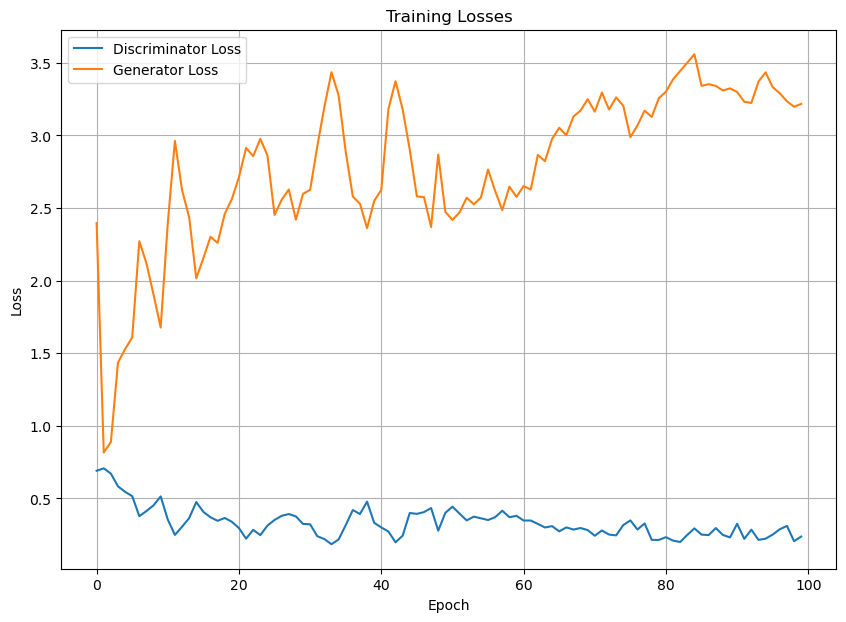

In [12]:
plt.figure(figsize=(10, 7))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.grid(True)
plt.legend()
plt.show()

In [13]:
dataset[23454][1].shape

torch.Size([1, 64, 64])

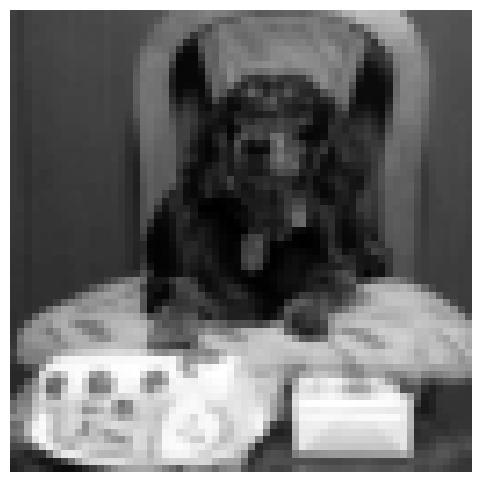

In [19]:
plot_l(dataset[234][1])

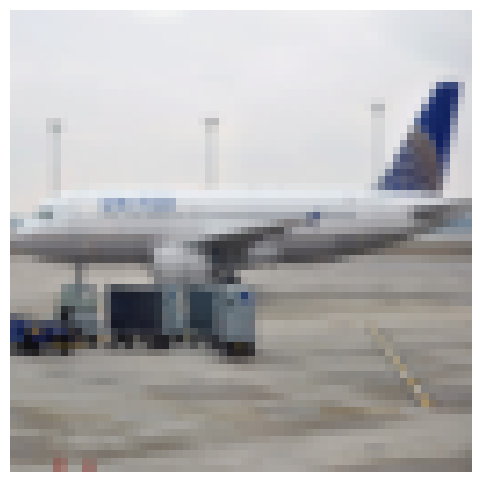

In [30]:
plot_rgb(dataset[7653][0])

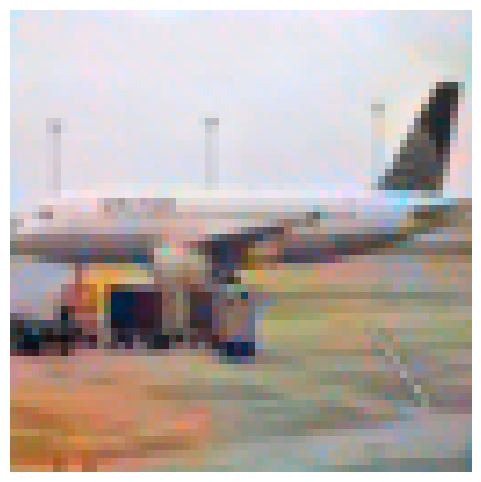

In [31]:
input = dataset[7653][1].to(device).unsqueeze(0)
ab = generator(input).squeeze(0)
reconstruct_lab(dataset[7653][1].to(device).detach().cpu(), ab.detach().cpu())
# fai controllo dimensioni per plot

# Load 

In [17]:
loaded_model = load_model(Generator(), "models/generator.pth").to(device)

Generator model loaded successfully!
